In [1]:
import os
import sys

#Import config file. Update config.py according to your environment
import config

import pandas as pd
import numpy as np

from Rakuten_preprocessing import Rakuten_img_path

from src.text.classifiers import TFbertClassifier
from src.image.classifiers import ImgClassifier
from src.multimodal.classifiers import TFmultiClassifier

from src.utils.load import load_classifier

from src.utils.visualize import deepCAM, plot_weighted_text

import cv2

/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

2024-03-18 05:34:21.903985: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 05:34:21.926783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 05:34:21.926806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 05:34:21.927502: E external/local_xla/xla/stream_execut

## Loading the data

In [2]:
data_train = pd.read_csv(os.path.join(config.path_to_data, 'df_train_index.csv'))
data_train['testset'] = False
data_test = pd.read_csv(os.path.join(config.path_to_data, 'df_test_index.csv'))
data_test['testset'] = True
data = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)

#merging text into token column
colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
data['tokens'] = data[colnames].apply(lambda row: ' '.join(s.lower() for s in row if isinstance(s, str)), axis=1)

#path to images into img_path column
data['img_path'] = Rakuten_img_path(img_folder=config.path_to_images,
                             imageid=data['imageid'], productid=data['productid'], suffix='_resized')

In [3]:
#labels of encoded classes
class_labels = data.groupby('prdtypedesignation')['prdtypeindex'].first().reset_index()
class_labels.index = class_labels['prdtypeindex']
class_labels = class_labels.drop(columns='prdtypeindex').sort_index()

## Loading the model

In [4]:
# clf_resnet = load_classifier('image/ResNet152')
# clf_vit = load_classifier('image/vit_b16')
# clf_bert = load_classifier('text/camembert-base-ccnet')
clf_fusion = load_classifier('fusion/camembert-base-vit_b16_TF6_att12')

2024-03-18 05:34:31.866588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 05:34:31.886882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 05:34:31.886928: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 05:34:31.889126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 05:34:31.889172: I external/local_xla/xla/stream_executor

loading weights for multimodal model from  fusion/camembert-base-vit_b16_TF6_att12


## Instantiating the deepCAM with the classifier

In [5]:
icam = deepCAM(clf_fusion)

All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/justj/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Compute Masks for a given entry

In [26]:
#Pick some data
idx = 0
image = cv2.imread(data['img_path'][idx])
text = data['tokens'][idx]
X = {'text': text, 'image': image}

#Compute masks and maasked inputs
icam.computeMaskedInput(X, min_factor=0.0);

1/1 [==============================] - 1s 1s/step


## Plot the original inputs and the deepCAM masked inputs

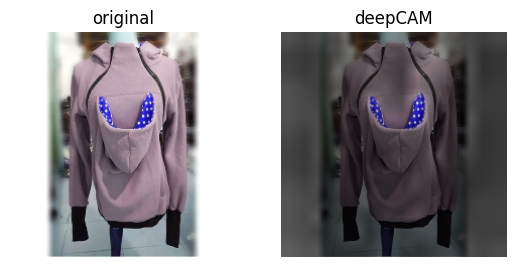

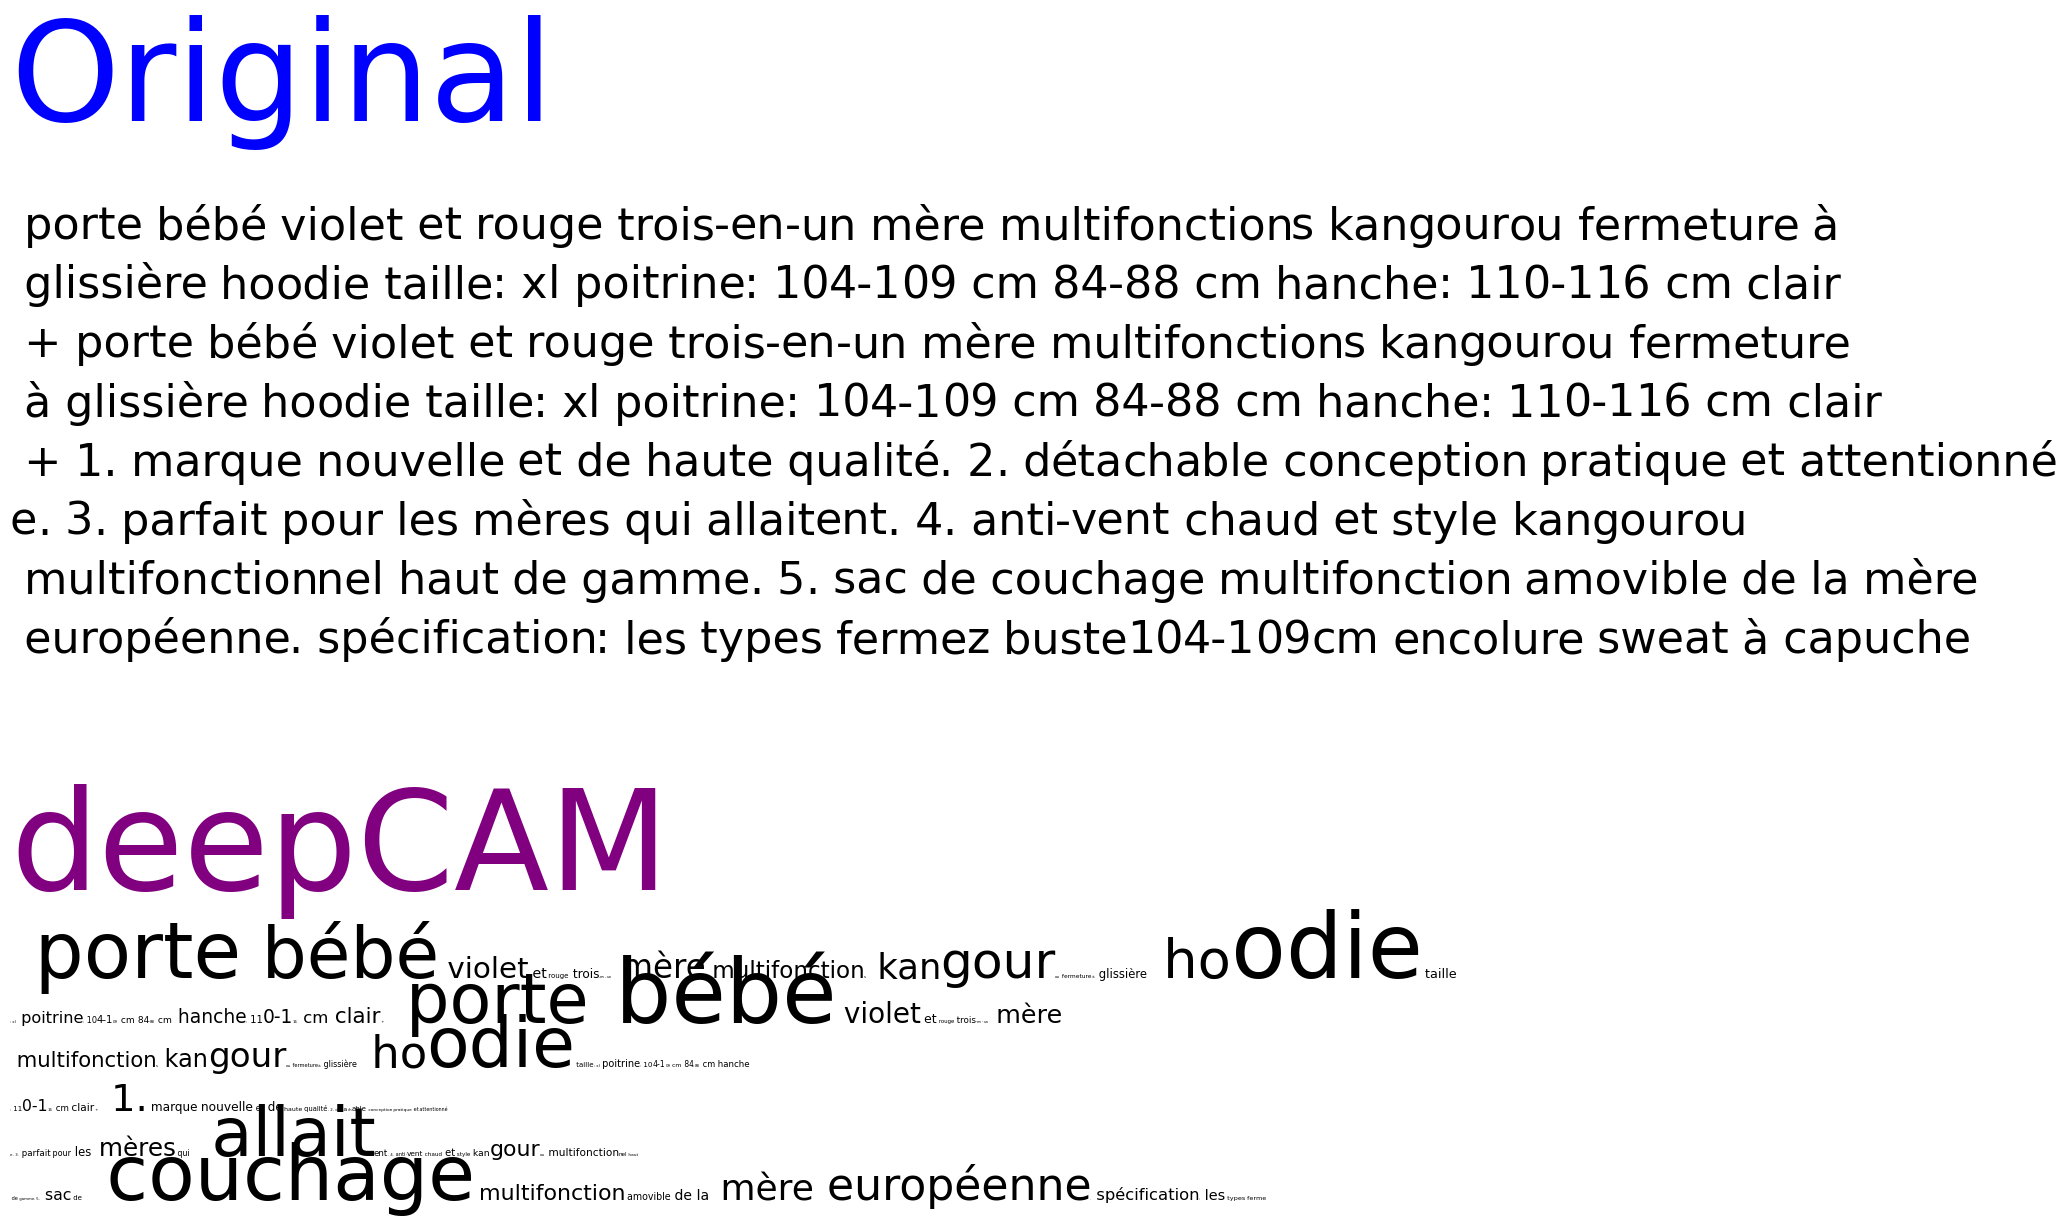

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(icam.image);
ax[0].axis('off')
ax[0].set_title('original')
ax[1].imshow(icam.image_masked);
ax[1].axis('off')
ax[1].set_title('deepCAM')

plt.show()

fig, ax = plt.subplots()
plot_weighted_text(0, 0.7, icam.text, icam.text_masked*0+0.4, base_font_size=80, char_per_line=80, title='Original', title_color='blue', title_fontsize=100, ax=ax)
plot_weighted_text(0, ax.get_ylim()[0], icam.text, icam.text_masked*5, base_font_size=60, char_per_line=100, title='deepCAM', title_color='purple', title_fontsize=100, ax=ax)
plt.show()